From: https://github.com/tensorflow/tensorflow/blob/master/tensorflow/examples/tutorials/word2vec/word2vec_basic.py

In [21]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import collections
import math
import os
import random
import zipfile

import numpy as np
from six.moves import urllib
from six.moves import xrange  # pylint: disable=redefined-builtin
import tensorflow as tf

import sklearn
import matplotlib
%matplotlib inline
import scipy
import string
import nltk

## WBC

### Step 1: Get the Data.
#### Example from orignial code below.

In [22]:
from string import punctuation
def strip_punctuation(s):
    return ''.join(c for c in s if c not in punctuation)

In [23]:
subdir = '/Users/leighharton/Documents/MSDS/Capstone/WBC'
#filepath = subdir + "/WBC001.txt"

In [60]:
#vocabulary = open(filepath).read()
#vocabulary = vocabulary.lower()
#vocabulary = strip_punctuation(vocabulary)
#vocabulary = nltk.word_tokenize(vocabulary)

In [25]:
vocabulary = []
for i in range(423):
    if i < 9:
        filepath = subdir + "/WBC00" + str(i+1) + ".txt"
        words = open(filepath).read()
        words = words.lower()
        words = strip_punctuation(words)
        words = nltk.word_tokenize(words)
        #vocabulary = vocabulary + words
    elif i < 99:
        filepath = subdir + "/WBC0" + str(i+1) + ".txt"
        words = open(filepath).read()
        words = words.lower()
        words = strip_punctuation(words)
        words = nltk.word_tokenize(words)
    else:
        filepath = subdir + "/WBC" + str(i+1) + ".txt"
        words = open(filepath).read()
        words = words.lower()
        words = strip_punctuation(words)
        words = nltk.word_tokenize(words)
    vocabulary = vocabulary + words

In [26]:
len(vocabulary)

1351279

### Step 2: Build the dictionary and replace rare words with UNK token.

In [27]:
vocabulary_size = 20000 # orignial was 50000

"""Process raw inputs into a dataset."""
def build_dataset(words, n_words):
    count = [['UNK', -1]]
    count.extend(collections.Counter(words).most_common(n_words - 1))
    dictionary = dict()
    for word, _ in count:
        dictionary[word] = len(dictionary)
    data = list()
    unk_count = 0
    for word in words:
        if word in dictionary:
            index = dictionary[word]
        else:
            index = 0  # dictionary['UNK']
            unk_count += 1
        data.append(index)
    count[0][1] = unk_count
    reversed_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
    return data, count, dictionary, reversed_dictionary

data, count, dictionary, reverse_dictionary = build_dataset(vocabulary,
                                                            vocabulary_size)
del vocabulary  # Hint to reduce memory.
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10], [reverse_dictionary[i] for i in data[:10]])

data_index = 0

Most common words (+UNK) [['UNK', 11238], ('the', 87564), ('and', 59487), ('of', 55519), ('to', 34720)]
Sample data [124, 89, 1074, 1055, 220, 103, 105, 565, 193, 18] ['sunday', 'may', '27', '2007', 'page', '1', 'sermon', 'outline', 'away', 'with']


### Step 3: Function to generate a training batch for the skip-gram model.

In [28]:
def generate_batch(batch_size, num_skips, skip_window):
    global data_index
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    span = 2 * skip_window + 1  # [ skip_window target skip_window ]
    buffer = collections.deque(maxlen=span)
    for _ in range(span):
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    for i in range(batch_size // num_skips):
        target = skip_window  # target label at the center of the buffer
        targets_to_avoid = [skip_window]
        for j in range(num_skips):
            while target in targets_to_avoid:
                target = random.randint(0, span - 1)
            targets_to_avoid.append(target)
            batch[i * num_skips + j] = buffer[skip_window]
            labels[i * num_skips + j, 0] = buffer[target]
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    # Backtrack a little bit to avoid skipping words in the end of a batch
    data_index = (data_index + len(data) - span) % len(data)
    return batch, labels

batch, labels = generate_batch(batch_size=8, num_skips=2, skip_window=1)
for i in range(8):
    print(batch[i], reverse_dictionary[batch[i]],'->', labels[i, 0], reverse_dictionary[labels[i, 0]])

89 may -> 1074 27
89 may -> 124 sunday
1074 27 -> 89 may
1074 27 -> 1055 2007
1055 2007 -> 1074 27
1055 2007 -> 220 page
220 page -> 103 1
220 page -> 1055 2007


### Step 4: Build and train a skip-gram model.

In [44]:
for i in xrange(vocabulary_size):
    if reverse_dictionary[i] == 'evil':
        print(i)

156


In [45]:
batch_size = 128
embedding_size = 300  # Dimension of the embedding vector.
skip_window = 1       # How many words to consider left and right.
num_skips = 2         # How many times to reuse an input to generate a label.

# We pick a random validation set to sample nearest neighbors. Here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent.
valid_size = 16     # Random set of words to evaluate similarity on.
valid_window = 100  # Only pick dev samples in the head of the distribution.
valid_examples = np.array([ 2, 34, 11, 38, 89,  0, 37, 67, 
                           20, 86,  7,  6, 95, 97, 54, 156])
                            # so we can choose which words to graph
#valid_examples = np.random.choice(valid_window, valid_size, replace=False)
num_sampled = 64    # Number of negative examples to sample.

graph = tf.Graph()

with graph.as_default():
    # Input data.
    train_inputs = tf.placeholder(tf.int32, shape=[batch_size])
    train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

    # Ops and variables pinned to the CPU because of missing GPU implementation
    with tf.device('/cpu:0'):
        # Look up embeddings for inputs.
        embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
        embed = tf.nn.embedding_lookup(embeddings, train_inputs)
        
        # Construct the variables for the NCE loss
        nce_weights = tf.Variable(tf.truncated_normal([vocabulary_size, embedding_size],
                            stddev=1.0 / math.sqrt(embedding_size)))
        nce_biases = tf.Variable(tf.zeros([vocabulary_size]))
        
        # Compute the average NCE loss for the batch.
        # tf.nce_loss automatically draws a new sample of the negative labels each
        # time we evaluate the loss.
    loss = tf.reduce_mean(tf.nn.nce_loss(weights=nce_weights,
                                         biases=nce_biases,
                                         labels=train_labels,
                                         inputs=embed,
                                         num_sampled=num_sampled,
                                         num_classes=vocabulary_size))
        
    # Construct the SGD optimizer using a learning rate of 1.0.
    optimizer = tf.train.GradientDescentOptimizer(1.0).minimize(loss)
        
    # Compute the cosine similarity between minibatch examples and all embeddings.
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
    normalized_embeddings = embeddings / norm
    valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
    similarity = tf.matmul(valid_embeddings, normalized_embeddings, transpose_b=True)
        
    # Add variable initializer.
    init = tf.initialize_all_variables()

### Step 5: Begin training.

In [46]:
num_steps = 100001

with tf.Session(graph=graph) as session:
    # We must initialize all variables before we use them.
    init.run()
    print('Initialized')
    
    average_loss = 0
    for step in xrange(num_steps):
        batch_inputs, batch_labels = generate_batch(batch_size, num_skips, skip_window)
        feed_dict = {train_inputs: batch_inputs, train_labels: batch_labels}
        
        # We perform one update step by evaluating the optimizer op (including it
        # in the list of returned values for session.run()
        _, loss_val = session.run([optimizer, loss], feed_dict=feed_dict)
        average_loss += loss_val
        
        if step % 2000 == 0:
            if step > 0:
                average_loss /= 2000
                # The average loss is an estimate of the loss over the last 2000 batches.
            print('Average loss at step ', step, ': ', average_loss)
            average_loss = 0
        
        # Note that this is expensive (~20% slowdown if computed every 500 steps)
        if step % 10000 == 0:
            sim = similarity.eval()
            for i in xrange(valid_size):
                valid_word = reverse_dictionary[valid_examples[i]]
                top_k = 10  # number of nearest neighbors
                nearest = (-sim[i, :]).argsort()[1:top_k + 1]
                log_str = 'Nearest to %s:' % valid_word
                for k in xrange(top_k):
                    close_word = reverse_dictionary[nearest[k]]
                    log_str = '%s %s,' % (log_str, close_word)
                print(log_str)
    
    final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step  0 :  261.735656738
Nearest to and: worries, shaking, defenced, 24445, molded, immutable, assaying, 12930, equipment, undertakes,
Nearest to by: clearer, 1898, looseliving, philemons, counsel, 313, scepters, glittering, birthday, mexican,
Nearest to it: menace, resound, hungred, occult, highpriest, desk, obliges, waving, meetinghouse, killed,
Nearest to will: 23710, imply, clutches, murder, imprecation, beautifully, leavened, domination, 61113, refused,
Nearest to may: lucet, salome, sir, flags, assuming, brazen, 92224, calif, vicinity, 221620,
Nearest to UNK: pleasurable, clung, gloomy, completed, armed, archangel, class, meantime, shame, fortify,
Nearest to unto: saturation, mercifully, owens, shackles, amendments, i’m, 1134, accuse, citizen, stubbornness,
Nearest to things: respect, 2911, ouai, convince, presidents, impelled, shop, chronic, lighteth, coverup,
Nearest to are: fleeing, threshingfloors, plundered, stirring, loftiness, shockingbible, cel

In [48]:
embed_a = final_embeddings[156]
word = reverse_dictionary[156]
top_k = 10
nearest = (-sim[15, :]).argsort()[1:top_k + 1]
log_str = 'Nearest to %s:' % word
for k in xrange(top_k):
    close_word = reverse_dictionary[nearest[k]]
    if k == 0:
        embed_b = final_embeddings[nearest[k]]
    if k == 1:
        embed_c = final_embeddings[nearest[k]]
    if k == 2:
        embed_d = final_embeddings[nearest[k]]
    if k == 3:
        embed_e = final_embeddings[nearest[k]]
    if k == 4:
        embed_f = final_embeddings[nearest[k]]
    if k == 5:
        embed_g = final_embeddings[nearest[k]]
    if k == 6:
        embed_h = final_embeddings[nearest[k]]
    if k == 7:
        embed_i = final_embeddings[nearest[k]]
    if k == 8:
        embed_j = final_embeddings[nearest[k]]
    if k == 9:
        embed_k = final_embeddings[nearest[k]]     
    log_str = '%s %s,' % (log_str, close_word)
print(log_str)

Nearest to evil: suspended, womenservants, shinto, education, life, forbid, jehoshua, drowned, rump, UNK,


In [51]:
WBC_wv = np.vstack((embed_a,embed_b,embed_c,embed_d,embed_e,embed_f,embed_g,
                    embed_h,embed_i,embed_j,embed_k))
print(type(WBC_wv))
print(WBC_wv.shape)


WBC_vocab = ('evil', 'suspended', 'womenservants', 'shinto', 'education', 'life',
             'forbid', 'jehoshua', 'drowned', 'rump', 'UNK')
print(type(WBC_vocab))
print(len(WBC_vocab))

<type 'numpy.ndarray'>
(11, 300)
<type 'tuple'>
11


### Step 6: Visualize the embeddings.

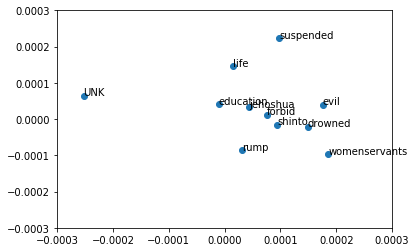

In [55]:
tsne = TSNE(n_components=2, random_state=0)
np.set_printoptions(suppress=True)
Y = tsne.fit_transform(WBC_wv[:11,:])
 
plt.scatter(Y[:, 0], Y[:, 1])
plt.axis([-0.0003,0.0003,-0.0003,0.0003])
for label, x, y in zip(WBC_vocab, Y[:, 0], Y[:, 1]):
    plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
plt.show()

## John Piper

### Step 1: Get the Data.

In [62]:
subdir = '/Users/leighharton/Documents/MSDS/Capstone/JohnPiper'
#filepath = subdir + "/JohnPiper001.txt"

In [63]:
vocabulary = []
for i in range(579):
    if i < 9:
        filepath = subdir + "/JohnPiper00" + str(i+1) + ".txt"
        words = open(filepath).read()
        words = words.lower()
        words = strip_punctuation(words)
        words = nltk.word_tokenize(words)
        #vocabulary = vocabulary + words
    elif i < 99:
        filepath = subdir + "/JohnPiper0" + str(i+1) + ".txt"
        words = open(filepath).read()
        words = words.lower()
        words = strip_punctuation(words)
        words = nltk.word_tokenize(words)
    else:
        filepath = subdir + "/JohnPiper" + str(i+1) + ".txt"
        words = open(filepath).read()
        words = words.lower()
        words = strip_punctuation(words)
        words = nltk.word_tokenize(words)
    vocabulary = vocabulary + words

In [64]:
len(vocabulary)

1537468

### Step 2: Build the dictionary and replace rare words with UNK token.

In [65]:
vocabulary_size = 20000 # orignial was 50000

"""Process raw inputs into a dataset."""
def build_dataset(words, n_words):
    count = [['UNK', -1]]
    count.extend(collections.Counter(words).most_common(n_words - 1))
    dictionary = dict()
    for word, _ in count:
        dictionary[word] = len(dictionary)
    data = list()
    unk_count = 0
    for word in words:
        if word in dictionary:
            index = dictionary[word]
        else:
            index = 0  # dictionary['UNK']
            unk_count += 1
        data.append(index)
    count[0][1] = unk_count
    reversed_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
    return data, count, dictionary, reversed_dictionary

data, count, dictionary, reverse_dictionary = build_dataset(vocabulary,
                                                            vocabulary_size)
del vocabulary  # Hint to reduce memory.
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10], [reverse_dictionary[i] for i in data[:10]])

data_index = 0

Most common words (+UNK) [['UNK', 27504], ('the', 94854), ('and', 56556), ('of', 53648), ('to', 44191)]
Sample data [42, 1, 55, 1029, 282, 189, 2, 329, 294, 14] ['if', 'the', 'lord', 'wills', 'both', 'today', 'and', 'next', 'week', 'we']


### Step 3: Function to generate a training batch for the skip-gram model.

In [66]:
def generate_batch(batch_size, num_skips, skip_window):
    global data_index
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    span = 2 * skip_window + 1  # [ skip_window target skip_window ]
    buffer = collections.deque(maxlen=span)
    for _ in range(span):
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    for i in range(batch_size // num_skips):
        target = skip_window  # target label at the center of the buffer
        targets_to_avoid = [skip_window]
        for j in range(num_skips):
            while target in targets_to_avoid:
                target = random.randint(0, span - 1)
            targets_to_avoid.append(target)
            batch[i * num_skips + j] = buffer[skip_window]
            labels[i * num_skips + j, 0] = buffer[target]
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    # Backtrack a little bit to avoid skipping words in the end of a batch
    data_index = (data_index + len(data) - span) % len(data)
    return batch, labels

batch, labels = generate_batch(batch_size=8, num_skips=2, skip_window=1)
for i in range(8):
    print(batch[i], reverse_dictionary[batch[i]],'->', labels[i, 0], reverse_dictionary[labels[i, 0]])

1 the -> 55 lord
1 the -> 42 if
55 lord -> 1 the
55 lord -> 1029 wills
1029 wills -> 55 lord
1029 wills -> 282 both
282 both -> 1029 wills
282 both -> 189 today


### Step 4: Build and train a skip-gram model.

In [67]:
for i in xrange(vocabulary_size):
    if reverse_dictionary[i] == 'evil':
        print(i)

261


In [68]:
batch_size = 128
embedding_size = 300  # Dimension of the embedding vector.
skip_window = 1       # How many words to consider left and right.
num_skips = 2         # How many times to reuse an input to generate a label.

# We pick a random validation set to sample nearest neighbors. Here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent.
valid_size = 16     # Random set of words to evaluate similarity on.
valid_window = 100  # Only pick dev samples in the head of the distribution.
valid_examples = np.array([ 2, 34, 11, 38, 89,  0, 37, 67, 
                           20, 86,  7,  6, 95, 97, 54, 261])
                            # so we can choose which words to graph
#valid_examples = np.random.choice(valid_window, valid_size, replace=False)
num_sampled = 64    # Number of negative examples to sample.

graph = tf.Graph()

with graph.as_default():
    # Input data.
    train_inputs = tf.placeholder(tf.int32, shape=[batch_size])
    train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

    # Ops and variables pinned to the CPU because of missing GPU implementation
    with tf.device('/cpu:0'):
        # Look up embeddings for inputs.
        embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
        embed = tf.nn.embedding_lookup(embeddings, train_inputs)
        
        # Construct the variables for the NCE loss
        nce_weights = tf.Variable(tf.truncated_normal([vocabulary_size, embedding_size],
                            stddev=1.0 / math.sqrt(embedding_size)))
        nce_biases = tf.Variable(tf.zeros([vocabulary_size]))
        
        # Compute the average NCE loss for the batch.
        # tf.nce_loss automatically draws a new sample of the negative labels each
        # time we evaluate the loss.
    loss = tf.reduce_mean(tf.nn.nce_loss(weights=nce_weights,
                                         biases=nce_biases,
                                         labels=train_labels,
                                         inputs=embed,
                                         num_sampled=num_sampled,
                                         num_classes=vocabulary_size))
        
    # Construct the SGD optimizer using a learning rate of 1.0.
    optimizer = tf.train.GradientDescentOptimizer(1.0).minimize(loss)
        
    # Compute the cosine similarity between minibatch examples and all embeddings.
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
    normalized_embeddings = embeddings / norm
    valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
    similarity = tf.matmul(valid_embeddings, normalized_embeddings, transpose_b=True)
        
    # Add variable initializer.
    init = tf.initialize_all_variables()

### Step 5: Begin training.

In [69]:
num_steps = 100001

with tf.Session(graph=graph) as session:
    # We must initialize all variables before we use them.
    init.run()
    print('Initialized')
    
    average_loss = 0
    for step in xrange(num_steps):
        batch_inputs, batch_labels = generate_batch(batch_size, num_skips, skip_window)
        feed_dict = {train_inputs: batch_inputs, train_labels: batch_labels}
        
        # We perform one update step by evaluating the optimizer op (including it
        # in the list of returned values for session.run()
        _, loss_val = session.run([optimizer, loss], feed_dict=feed_dict)
        average_loss += loss_val
        
        if step % 2000 == 0:
            if step > 0:
                average_loss /= 2000
                # The average loss is an estimate of the loss over the last 2000 batches.
            print('Average loss at step ', step, ': ', average_loss)
            average_loss = 0
        
        # Note that this is expensive (~20% slowdown if computed every 500 steps)
        if step % 10000 == 0:
            sim = similarity.eval()
            for i in xrange(valid_size):
                valid_word = reverse_dictionary[valid_examples[i]]
                top_k = 10  # number of nearest neighbors
                nearest = (-sim[i, :]).argsort()[1:top_k + 1]
                log_str = 'Nearest to %s:' % valid_word
                for k in xrange(top_k):
                    close_word = reverse_dictionary[nearest[k]]
                    log_str = '%s %s,' % (log_str, close_word)
                print(log_str)
    
    final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step  0 :  246.061569214
Nearest to and: beck, introduction, paralysis, machines, windows, covenantcommitment, dally, rushdies, manifestation, utters,
Nearest to by: starvation, goto, deadthe, overal, 152526, tear, 31719, june, worried, assurances,
Nearest to for: enslavements, disembodied, parables, vacancy, restraints, membership, persistence, aregoing, attribute, withme,
Nearest to jesus: 186, christwas, working, tax, brazil, bathed, fullness, reconciledto, selfdeception, samson,
Nearest to into: nobel, ai, maninka, floor, constructive, reads, unsafe, delightin, plot, UNK,
Nearest to UNK: 634, pastorsand, thegreatest, messiah, pentecost, glassdarkly, thatlove, into, stories, knell,
Nearest to they: were, questioned, ceases, persecutor, unpopular, surface, godsaturated, afuture, pertaining, butnow,
Nearest to gods: undergo, 1965, horoscope, specific, reconciler, cures, spurred, someone146s, knitter, opposing,
Nearest to are: fuse, majestic, nullifies, 1950

In [70]:
embed_a = final_embeddings[261]
word = reverse_dictionary[261]
top_k = 10
nearest = (-sim[15, :]).argsort()[1:top_k + 1]
log_str = 'Nearest to %s:' % word
for k in xrange(top_k):
    close_word = reverse_dictionary[nearest[k]]
    if k == 0:
        embed_b = final_embeddings[nearest[k]]
    if k == 1:
        embed_c = final_embeddings[nearest[k]]
    if k == 2:
        embed_d = final_embeddings[nearest[k]]
    if k == 3:
        embed_e = final_embeddings[nearest[k]]
    if k == 4:
        embed_f = final_embeddings[nearest[k]]
    if k == 5:
        embed_g = final_embeddings[nearest[k]]
    if k == 6:
        embed_h = final_embeddings[nearest[k]]
    if k == 7:
        embed_i = final_embeddings[nearest[k]]
    if k == 8:
        embed_j = final_embeddings[nearest[k]]
    if k == 9:
        embed_k = final_embeddings[nearest[k]]     
    log_str = '%s %s,' % (log_str, close_word)
print(log_str)

Nearest to evil: repaid, creatively, transgressor, specialize, fatalism, 50000, no, inthis, bitter, 712,


In [71]:
JohnPiper_wv = np.vstack((embed_a,embed_b,embed_c,embed_d,embed_e,embed_f,embed_g,
                    embed_h,embed_i,embed_j,embed_k))
print(type(JohnPiper_wv))
print(JohnPiper_wv.shape)


JohnPiper_vocab = ('evil', 'repaid', 'creatively', 'transgressor', 'specialize', 'fatalism',
             '500', 'no', 'inthis', 'bitter', '712')
print(type(JohnPiper_vocab))
print(len(JohnPiper_vocab))

<type 'numpy.ndarray'>
(11, 300)
<type 'tuple'>
11


### Step 6: Visualize the embeddings.

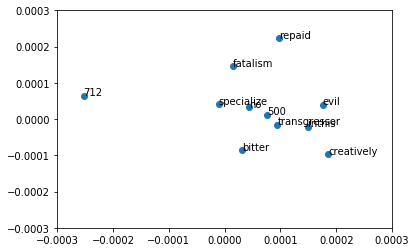

In [72]:
tsne = TSNE(n_components=2, random_state=0)
np.set_printoptions(suppress=True)
Y = tsne.fit_transform(JohnPiper_wv[:11,:])
 
plt.scatter(Y[:, 0], Y[:, 1])
plt.axis([-0.0003,0.0003,-0.0003,0.0003])
for label, x, y in zip(JohnPiper_vocab, Y[:, 0], Y[:, 1]):
    plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
plt.show()

### Extras

#### Import Data

In [2]:
url = 'http://mattmahoney.net/dc/'

"""Download a file if not present, and make sure it's the right size."""
def maybe_download(filename, expected_bytes):
    if not os.path.exists(filename):
        filename, _ = urllib.request.urlretrieve(url + filename, filename)
    statinfo = os.stat(filename)
    if statinfo.st_size == expected_bytes:
        print('Found and verified', filename)
    else:
        print(statinfo.st_size)
        raise Exception('Failed to verify ' + filename + '. Can you get to it with a browser?')
    return filename

filename = maybe_download('text8.zip', 31344016)

# Read the data into a list of strings.
"""Extract the first file enclosed in a zip file as a list of words."""
def read_data(filename):
    with zipfile.ZipFile(filename) as f:
        data = tf.compat.as_str(f.read(f.namelist()[0])).split()
    return data

vocabulary = read_data(filename)
print('Data size', len(vocabulary))

Found and verified text8.zip
Data size 17005207


#### Visualize Embeddings

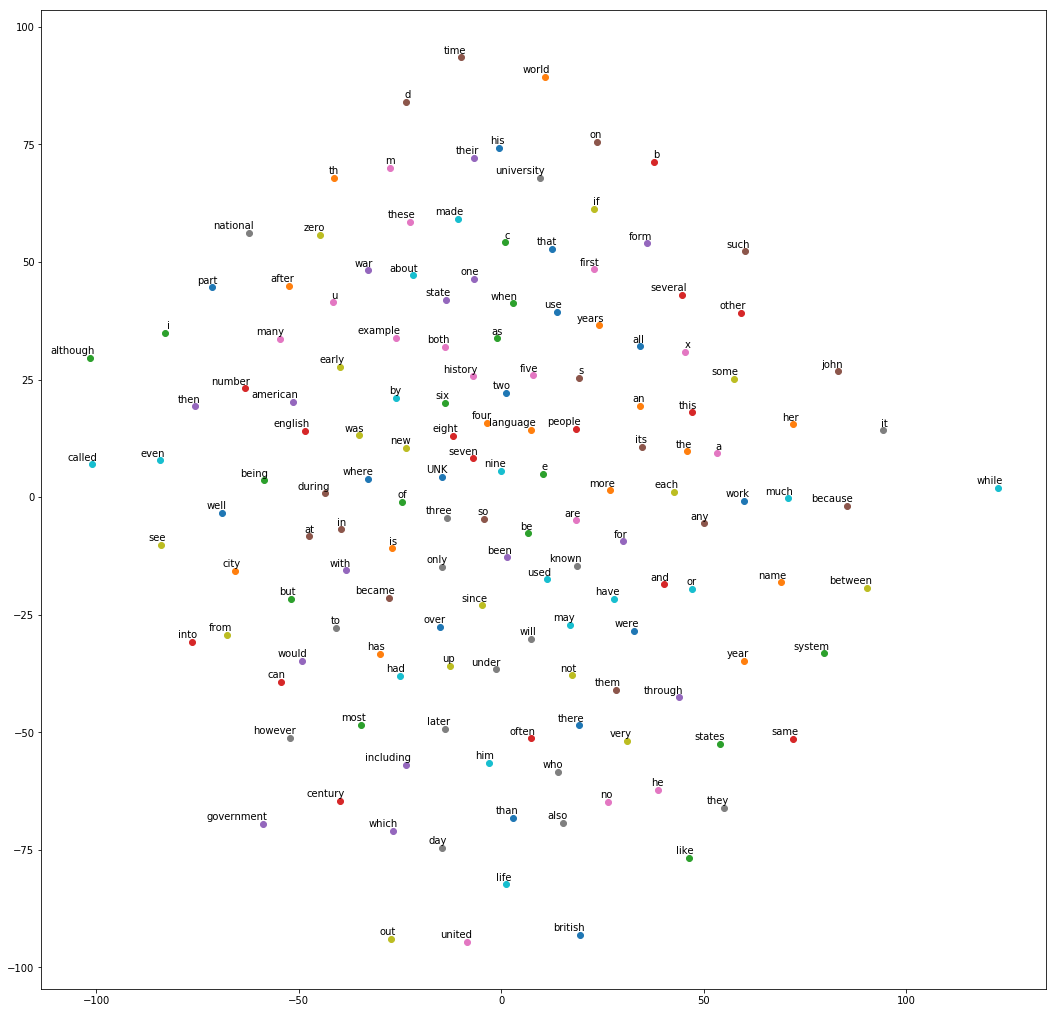

In [7]:
def plot_with_labels(low_dim_embs, labels, filename='tsne.png'):
    assert low_dim_embs.shape[0] >= len(labels), 'More labels than embeddings'
    plt.figure(figsize=(18, 18))  # in inches
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i, :]
        plt.scatter(x, y)
        plt.annotate(label,
                     xy=(x, y),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    
    plt.savefig(filename)

try:
    # pylint: disable=g-import-not-at-top
    from sklearn.manifold import TSNE
    import matplotlib.pyplot as plt
    
    tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
    plot_only = 150
    low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only, :])
    labels = [reverse_dictionary[i] for i in xrange(plot_only)]
    plot_with_labels(low_dim_embs, labels)

except ImportError:
    print('Please install sklearn, matplotlib, and scipy to show embeddings.')